In [1]:
import pandas as pd
import numpy as np
import mne
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix,make_scorer,classification_report
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
import numpy as np
from keras.optimizers import SGD
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import ShuffleSplit, cross_validate,GridSearchCV,RandomizedSearchCV,train_test_split
from sklearn.decomposition import PCA
from umap import UMAP
from sklearn.preprocessing import LabelEncoder
from mne.preprocessing import EOGRegression
import seaborn as sns
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

In [2]:
# !pip install umap-learn

In [3]:
np.set_printoptions(precision=6, suppress=True)

In [28]:

class FFT:
    def __init__(self,timeSeries,fs=160):
        self.getFFT(timeSeries,fs)

    def getFFT(self, timeSeries,fs=160):
        self.N = len(timeSeries)
        self.T = 1/fs
        self.t = np.arange(0,self.N/fs,self.T)
        f = np.fft.fftfreq(self.N,self.T)
        # self.data,self.f = np.abs(np.fft.fft(timeSeries))[f>0],f[f>0]
        self.data,self.f = np.real(np.fft.fft(timeSeries))[f>0],f[f>0]

    def plotFFT(self):
        plt.figure()
        plt.plot(self.f,(self.data)*(1/self.N))
        plt.show()
        return

    # filtragem da rede (intervalo indicado é de 0.5 até 42.0 hz)
    def bandPassFilter(self,min,max):
        self.data = self.data[(self.f>min) & (self.f<max)]
        self.f = self.f[(self.f>min) & (self.f<max)]
        return self
    
    def getDF(self):
        return pd.DataFrame(columns= self.f , data = self.data.reshape(1,len(self.f)))

    
def display_results(labels_test,rfc_pred):
    acc = accuracy_score(labels_test, rfc_pred)
    f1 = f1_score(labels_test, rfc_pred, average='macro')
    print(classification_report(labels_test,rfc_pred, digits=4))

    aux_df = labels_test.drop_duplicates().sort_values()
    conf_matrix = confusion_matrix(labels_test, rfc_pred)
    plt.figure(figsize=(12.8,6))
    sns.heatmap(conf_matrix, 
                annot=True,
                xticklabels=aux_df.values, 
                yticklabels=aux_df.values,
                cmap="Blues")
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion matrix')
    plt.show()
    return f1,acc

In [ ]:

metrics = []


subjects_range = range(1, 10)
for subject in subjects_range:
    fileName = f'../../datasources/BCICIV_2a_gdf/A{subject:02d}T.gdf'
    
    raw = mne.io.read_raw_gdf(fileName,preload=True, eog=['EOG-left', 'EOG-central', 'EOG-right'], verbose=0)


    raw.load_data()
    raw.set_eeg_reference("average")
    raw.filter(0, 120)

    eog_epochs = mne.preprocessing.create_eog_epochs(raw, l_freq=0, h_freq=120)
    # We need to explicitly specify that we want to average the EOG channel too.
    eog_evoked = eog_epochs.average("all")

    # apply the regression coefficients to the original epochs
    model_evoked = EOGRegression(picks="eeg", picks_artifact="eog").fit(eog_evoked)
    raw_clean = model_evoked.apply(raw)
    raw_clean.drop_channels(['EOG-left', 'EOG-central', 'EOG-right'])
    annotations = raw.annotations
    codes = annotations.description  
    codeArray = []     
    counter = 0

    df = pd.DataFrame(raw_clean.get_data().T, columns=[channel.replace(".","") for channel in raw_clean.ch_names])
    df = df[~(df == 0).all(axis=1)]
    # df = df[160:min(len(df),19680)] # Filter first and last values
    timeArray = np.array([round(x,5) for x in np.arange(0,len(df)/250,.004)])
    # timeArray = np.array([round(x,5) for x in np.arange(0,124.5,.00625)])

    for timeVal in timeArray:
        if timeVal in annotations.onset:
            counter += 1
        codeArray.append(codes[counter-1])

    df["target"] = np.array(codeArray[:len(df)]).T
    

    df.to_csv(f"../../treated_files/F_A{subject:02d}T.csv")


In [37]:

metrics = []


subjects_range = range(1, 10)
for subject in subjects_range:
    df = pd.read_csv(f"../../treated_files/F_A{subject:02d}T.csv",index_col= 0)

    # Iterate over unique target values
    window_size = 250
    shift_size = 125
    # for target_value in df['target'].unique():
        # Create a DataFrame for each target value
        # target_df = df[df['target'] == target_value]
        # target_df.reset_index(drop=True, inplace=True)
        # Create a list to store the windowed dataframes
    target_df = df
    # Iterate through the dataframe with the specified window and shift size
    for i in range(0, len(target_df) - window_size + 1, shift_size):
        
            # Extract the window of dat'a
            window_data = target_df.iloc[i:i + window_size]
            if len(window_data) == 250:
                if (window_data['target'][i] != np.max(window_data['target'][-1:]) ):
                    continue

                target = window_data['target'][i]
                # fft = FFT(window_data['EEG-Cz'],250)
                ffts = window_data.drop('target', axis=1).apply(lambda col: FFT(col, 250), axis=0)
                dfs = []
                for fft in ffts:
                    fft.bandPassFilter(0.5,42)
                    dfs.append( fft.getDF())
                merged_df = pd.concat(dfs, axis=1)
                # data = {
                #     'mean': [np.mean(fft.data)],
                #     'max': [np.max(fft.data)],
                #     'min': [np.min(fft.data)],
                #     'fmax': [fft.f[np.argmax(fft.data)]],
                #     'energy': [sum(np.abs(fft.data)*np.abs(fft.data))/len(fft.data)],
                #     'target': target
                # }
                
                merged_df['target'] = target
                metrics.append(merged_df)



    # df = df[df['target']!= "T0"]

    #         # Iterate over unique target values
    # window_size = 160
    # shift_size = 80
    # for target_value in df['target'].unique():
    #     target_df = df[df['target'] == target_value]
    #     target_df.reset_index(drop=True, inplace=True)
    # # target_df = df
    # # Iterate through the dataframe with the specified window and shift size
    #     for i in range(0, len(target_df) - window_size + 1, shift_size):
            
    #             # Extract the window of dat'a
    #             window_data = target_df[['Fp1','target']].iloc[i:i + window_size]
    #             if len(window_data) == 160:
    #                 fft = FFT(window_data['Fp1'])
    #                 fft.bandPassFilter(0.5,42)
    #                 data = {
    #                     'mean': [np.mean(fft.data)],
    #                     'max': [np.max(fft.data)],
    #                     'min': [np.min(fft.data)],
    #                     'fmax': [fft.f[np.argmax(fft.data)]],
    #                     'energy': [sum(np.abs(fft.data)*np.abs(fft.data))/len(fft.data)],
    #                     'target': window_data['target'][i]
    #                 }
    #                 metrics.append(pd.DataFrame(data))
                    
metrics = pd.concat(metrics, ignore_index=True)
metrics.to_csv("../dataframe/F_b2a-1-2-3-4-fft.csv")

In [ ]:
window_data.drop('target', axis=1).apply(lambda col: FFT(col, 250), axis=0)

In [38]:
metrics

,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,...,33.0,34.0,35.0,36.0,37.0,38.0,39.0,40.0,41.0,target
0,-0.000179,0.000264,2.577392e-04,-0.001176,-0.000268,-0.000065,-0.000274,-0.000269,-0.000024,-0.000186,...,4.038137e-05,1.806271e-05,-0.000039,-0.000069,0.000056,-0.000090,-0.000030,-0.000006,-0.000027,32766
1,0.000378,-0.000710,9.684318e-07,-0.001466,0.000866,-0.000540,0.000786,-0.000407,0.000109,0.000012,...,-3.448160e-05,2.002098e-05,-0.000007,0.000046,-0.000042,0.000009,-0.000012,0.000006,0.000027,32766
2,-0.000191,-0.001413,-1.662425e-05,-0.000739,-0.000482,-0.000584,-0.000448,-0.000122,0.000121,0.000222,...,-4.647609e-07,-2.789307e-05,-0.000061,0.000105,-0.000079,-0.000023,0.000006,0.000078,0.000012,32766
3,0.000203,-0.000519,-3.010951e-04,-0.000132,0.000003,-0.000076,0.000076,-0.000050,0.000016,-0.000072,...,-6.538204e-05,-4.452152e-05,0.000024,0.000098,0.000065,-0.000028,0.000055,0.000024,0.000030,32766
4,-0.000097,0.000243,7.494235e-05,0.000220,-0.000094,-0.000281,0.000027,-0.000080,-0.000110,-0.000126,...,8.812726e-05,-1.924981e-08,0.000084,0.000051,-0.000016,-0.000060,0.000003,-0.000070,-0.000035,32766
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37571,-0.000289,0.000733,1.715515e-04,0.000104,-0.000199,0.000013,-0.000444,0.000073,0.000462,0.000005,...,-4.133824e-05,-7.799819e-05,-0.000041,0.000028,0.000014,0.000006,0.000007,0.000009,-0.000012,768
37572,0.000046,0.000348,-6.607931e-04,-0.000077,0.000198,-0.000175,0.000303,-0.000053,-0.000053,-0.000006,...,6.571384e-06,-3.751559e-05,0.000026,0.000024,-0.000040,-0.000024,-0.000005,0.000018,-0.000024,768
37573,0.000218,-0.000180,8.590331e-06,-0.000395,0.000313,-0.000129,0.000029,-0.000231,-0.000211,0.000098,...,-4.335882e-06,1.005679e-05,-0.000001,-0.000039,-0.000019,-0.000046,0.000012,0.000020,0.000024,768
37574,0.000407,0.000158,4.577572e-05,-0.000169,-0.000079,0.000067,0.000125,0.000220,0.000099,-0.000005,...,4.144686e-05,2.127658e-05,-0.000022,-0.000005,0.000028,-0.000034,-0.000019,0.000023,-0.000006,768


In [ ]:
metrics = pd.read_csv("../dataframe/F_b2a-1-2-3-4-fft.csv",index_col=0)

In [ ]:
pca = PCA()
pca.fit(metrics.drop(columns='target'))

variancia_explicada_acumulada = np.cumsum(pca.explained_variance_ratio_)


fig, ax = plt.subplots(figsize=(10, 6))
eixo_x = list(range(1, len(variancia_explicada_acumulada)+1))
ax.plot(eixo_x, variancia_explicada_acumulada, marker="o")
ax.set_xlabel("Número de componentes principais")
ax.set_ylabel("Perceuntual de variância explicada acumulada")
ax.set_xticks(eixo_x)
plt.show()

In [ ]:
pd.DataFrame(variancia_explicada_acumulada)

In [ ]:
embeddings = pca.transform(metrics.drop(columns='target'))

In [ ]:
fig, ax = plt.subplots()
sns.scatterplot(ax = ax, x = pd.DataFrame(embeddings)[0],y=  pd.DataFrame(embeddings)[1], hue =  metrics['target'],palette="tab10")
ax.set_ylabel("Segunda componente Principal")
ax.set_xlabel("Primeira Componente Principal")
ax.legend(["Classe","T0","T1","T2"])
plt.show()

## umap = UMAP(random_state=42,n_neighbors=30,min_dist=0.05)

In [ ]:
umap = UMAP(random_state=42,n_neighbors=30,min_dist=0.05)


In [ ]:

label_encoder = LabelEncoder()
X_train_full, X_val, y_train_full, y_val = train_test_split(metrics.drop(columns='target'), label_encoder.fit_transform(metrics['target']), test_size=0.3, random_state=42)
umap.fit(X_train_full,y_train_full)


In [ ]:

umap_embeddings = umap.transform(X_train_full)
umap_embeddings_val = umap.transform(X_val)
umap_embeddings_all = umap.transform(metrics.drop(columns='target'))
umap_embeddings_test = umap.transform(pd.concat([X_train_full,X_val[:100]], ignore_index=True))



In [ ]:

fig, ax = plt.subplots()
sns.scatterplot(ax = ax, x = pd.DataFrame(umap_embeddings_val)[0],y=  pd.DataFrame(umap_embeddings_val)[1], hue =  y_val,palette="tab10")
ax.set_ylabel("Segunda componente")
ax.set_xlabel("Primeira Componente")
ax.legend(["Classe","T0","T1","T2"])
ax.set_xticks(list(range(-11, 11+1))) 
ax.set_yticks(list(range(-3, 13+1)))
plt.show()

In [ ]:
fig, ax = plt.subplots()
sns.scatterplot(ax = ax, x = pd.DataFrame(umap_embeddings)[0],y=  pd.DataFrame(umap_embeddings)[1], hue =  y_train_full,palette="tab10")
ax.set_ylabel("Segunda componente")
ax.set_xlabel("Primeira Componente")
ax.legend(["Classe","T0","T1","T2"])
ax.set_xticks(list(range(-11, 11+1))) 
ax.set_yticks(list(range(-3, 13+1)))

plt.show()

In [ ]:
fig, ax = plt.subplots()
sns.scatterplot(ax = ax, x = pd.DataFrame(umap_embeddings_test)[0],y=  pd.DataFrame(umap_embeddings_test)[1], hue =  pd.concat([pd.DataFrame(y_train_full),pd.DataFrame(y_val)[:100]], ignore_index=True)[0],palette="tab10")
ax.set_ylabel("Segunda componente")
ax.set_xlabel("Primeira Componente")
ax.legend(["Classe","T0","T1","T2"])
ax.set_xticks(list(range(-11, 11+1))) 
ax.set_yticks(list(range(-3, 13+1)))
plt.show()

In [ ]:
fig, ax = plt.subplots()
sns.scatterplot(ax = ax, x = pd.DataFrame(umap_embeddings_val)[:100][0],y=  pd.DataFrame(umap_embeddings_val)[:100][1], hue =  y_val[:100],palette="tab10")
ax.set_ylabel("Segunda componente")
ax.set_xlabel("Primeira Componente")
ax.legend(["Classe","T0","T1","T2"])
ax.set_xticks(list(range(-11, 11+1))) 
ax.set_yticks(list(range(-3, 13+1)))
plt.show()

fig, ax = plt.subplots()
sns.scatterplot(ax = ax, x = pd.DataFrame(umap_embeddings_test)[-100:][0],y=  pd.DataFrame(umap_embeddings_test)[-100:][1], hue =  pd.concat([pd.DataFrame(y_train_full),pd.DataFrame(y_val)[:100]], ignore_index=True)[-100:][0],palette="tab10")
ax.set_ylabel("Segunda componente")
ax.set_xlabel("Primeira Componente")
ax.legend(["Classe","T0","T1","T2"])
ax.set_xticks(list(range(-11, 11+1))) 
ax.set_yticks(list(range(-3, 13+1)))  
plt.show()

In [ ]:
fig, ax = plt.subplots()
sns.scatterplot(ax = ax, x = pd.DataFrame(umap_embeddings_all)[0],y=  pd.DataFrame(umap_embeddings_all)[1], hue =   label_encoder.transform(metrics['target']),palette="tab10")
ax.set_ylabel("Segunda componente")
ax.set_xlabel("Primeira Componente")
ax.legend(["Classe","T0","T1","T2"])
ax.set_xticks(list(range(-11, 11+1))) 
ax.set_yticks(list(range(-3, 13+1)))         
plt.show()
fig, ax = plt.subplots()
sns.scatterplot(ax = ax, x = pd.concat([pd.DataFrame(umap_embeddings),pd.DataFrame(umap_embeddings_val)], ignore_index=True)[0],y=  pd.concat([pd.DataFrame(umap_embeddings),pd.DataFrame(umap_embeddings_val)], ignore_index=True)[1], hue =   pd.concat([pd.DataFrame(y_train_full),pd.DataFrame(y_val)], ignore_index=True)[0],palette="tab10")
ax.set_ylabel("Segunda componente")
ax.set_xlabel("Primeira Componente")
ax.legend(["Classe","T0","T1","T2"])
ax.set_xticks(list(range(-11, 11+1))) 
ax.set_yticks(list(range(-3, 13+1)))
plt.show()

## UMAP(random_state=42,n_neighbors=20,min_dist=0.05)

In [ ]:
umap = UMAP(random_state=42,n_neighbors=20,min_dist=0.05)

In [ ]:
label_encoder = LabelEncoder()
X_train_full, X_val, y_train_full, y_val = train_test_split(metrics.drop(columns='target'), label_encoder.fit_transform(metrics['target']), test_size=0.3, random_state=42)
umap.fit(X_train_full,y_train_full)


In [ ]:

umap_embeddings = umap.transform(X_train_full)
umap_embeddings_val = umap.transform(X_val)
umap_embeddings_all = umap.transform(metrics.drop(columns='target'))
umap_embeddings_test = umap.transform(pd.concat([X_train_full,X_val[:100]], ignore_index=True))



In [ ]:

fig, ax = plt.subplots()
sns.scatterplot(ax = ax, x = pd.DataFrame(umap_embeddings_val)[0],y=  pd.DataFrame(umap_embeddings_val)[1], hue =  y_val,palette="tab10")
ax.set_ylabel("Segunda componente")
ax.set_xlabel("Primeira Componente")
ax.legend(["Classe","T0","T1","T2"])
ax.set_xticks(list(range(-11, 11+1))) 
ax.set_yticks(list(range(-3, 13+1)))
plt.show()

In [ ]:
fig, ax = plt.subplots()
sns.scatterplot(ax = ax, x = pd.DataFrame(umap_embeddings)[0],y=  pd.DataFrame(umap_embeddings)[1], hue =  y_train_full,palette="tab10")
ax.set_ylabel("Segunda componente")
ax.set_xlabel("Primeira Componente")
ax.legend(["Classe","T0","T1","T2"])
ax.set_xticks(list(range(-11, 11+1))) 
ax.set_yticks(list(range(-3, 13+1)))

plt.show()

In [ ]:
fig, ax = plt.subplots()
sns.scatterplot(ax = ax, x = pd.DataFrame(umap_embeddings_test)[0],y=  pd.DataFrame(umap_embeddings_test)[1], hue =  pd.concat([pd.DataFrame(y_train_full),pd.DataFrame(y_val)[:100]], ignore_index=True)[0],palette="tab10")
ax.set_ylabel("Segunda componente")
ax.set_xlabel("Primeira Componente")
ax.legend(["Classe","T0","T1","T2"])
ax.set_xticks(list(range(-11, 11+1))) 
ax.set_yticks(list(range(-3, 13+1)))
plt.show()

In [ ]:
fig, ax = plt.subplots()
sns.scatterplot(ax = ax, x = pd.DataFrame(umap_embeddings_val)[:100][0],y=  pd.DataFrame(umap_embeddings_val)[:100][1], hue =  y_val[:100],palette="tab10")
ax.set_ylabel("Segunda componente")
ax.set_xlabel("Primeira Componente")
ax.legend(["Classe","T0","T1","T2"])
ax.set_xticks(list(range(-11, 11+1))) 
ax.set_yticks(list(range(-3, 13+1)))
plt.show()

fig, ax = plt.subplots()
sns.scatterplot(ax = ax, x = pd.DataFrame(umap_embeddings_test)[-100:][0],y=  pd.DataFrame(umap_embeddings_test)[-100:][1], hue =  pd.concat([pd.DataFrame(y_train_full),pd.DataFrame(y_val)[:100]], ignore_index=True)[-100:][0],palette="tab10")
ax.set_ylabel("Segunda componente")
ax.set_xlabel("Primeira Componente")
ax.legend(["Classe","T0","T1","T2"])
ax.set_xticks(list(range(-11, 11+1))) 
ax.set_yticks(list(range(-3, 13+1)))  
plt.show()

In [ ]:
fig, ax = plt.subplots()
sns.scatterplot(ax = ax, x = pd.DataFrame(umap_embeddings_all)[0],y=  pd.DataFrame(umap_embeddings_all)[1], hue =   label_encoder.transform(metrics['target']),palette="tab10")
ax.set_ylabel("Segunda componente")
ax.set_xlabel("Primeira Componente")
ax.legend(["Classe","T0","T1","T2"])
ax.set_xticks(list(range(-11, 11+1))) 
ax.set_yticks(list(range(-3, 13+1)))         
plt.show()
fig, ax = plt.subplots()
sns.scatterplot(ax = ax, x = pd.concat([pd.DataFrame(umap_embeddings),pd.DataFrame(umap_embeddings_val)], ignore_index=True)[0],y=  pd.concat([pd.DataFrame(umap_embeddings),pd.DataFrame(umap_embeddings_val)], ignore_index=True)[1], hue =   pd.concat([pd.DataFrame(y_train_full),pd.DataFrame(y_val)], ignore_index=True)[0],palette="tab10")
ax.set_ylabel("Segunda componente")
ax.set_xlabel("Primeira Componente")
ax.legend(["Classe","T0","T1","T2"])
ax.set_xticks(list(range(-11, 11+1))) 
ax.set_yticks(list(range(-3, 13+1)))
plt.show()

## Conclusão do UMAP

É interessante que o transforme de todos os dados juntos é diferente da união das transformadas do treino e teste. Isso indica que o processo de transform do UMAP leva em consideração todos os pontos, ao invés de apenas classificar um a um. 

Apesar de estranho, não da pra afirmar que há uma melhora real em qualquer um dos dois processos descritos acima, como podemos ver no exemplo de teste, em que claramente os novos pontos se distribuiram de forma pouco relevante quando comparados aos dados de treino anteriormente vistos pelo modelo. Isso pode indicar que o prórpio modelo está em overfit, já que os dados de treino tem uma classificação melhor que os dados não vistos anteriormente pelo modelo. 

A princípio, comparando lado a lado os dois experimentos acima, o conjunto de validação que foi mostrado junto com o conjunto de treino possui uma distribuição mais agrupada. Apesar disso, como normalmente essa amostragem deve ser feita de forma separada, iremos seguir o procedimento tradicional.

Essa visualização preliminar é apenas para demonstrar as capacidades do UMAP. No modelo final iremos utilizar o mesmo número de componentes que o PCA.

In [39]:
metrics_filtered = metrics[metrics['target'].isin([
    # 768,
    769,
    770,
    # 771,  772
    ])]


In [40]:
metricsT2 = metrics_filtered.copy()
metricsT1 = metrics_filtered.copy()
# metricsT2 = metrics[metrics['target']!= "T0"].copy()
# metricsT1 = metrics[metrics['target']!= "T0"].copy()

In [41]:
metricsT2.loc[metricsT2['target'] != 769, 'target'] = 0
metricsT2.loc[metricsT2['target'] == 769, 'target'] = 1

metricsT1.loc[metricsT1['target'] != 770, 'target'] = 0
metricsT1.loc[metricsT1['target'] == 770, 'target'] = 1


In [42]:
df = metricsT1.copy()

In [43]:
len(metrics)

37576

In [44]:
len(metricsT2)

7148

In [45]:
len(metricsT1)

7148

In [46]:

# Supondo que você tenha os dados X e y para treinamento
label_encoder = LabelEncoder()
X_train, X_val, y_train, y_val = train_test_split(df.drop(columns='target'), label_encoder.fit_transform(df['target']), test_size=0.3, random_state=42)




In [47]:
len(X_val)

2145

In [48]:

# Definir o número de folds para a validação cruzada


model = MLPClassifier(learning_rate_init= 0.3,max_iter= 500,momentum= 0.2,hidden_layer_sizes= (6, 3))

random_grid = {
               'activation': ['logistic'],
               'solver': ['sgd'],
               
               
               }


random_search = RandomizedSearchCV(estimator= model,param_distributions=random_grid,refit='Accuracy',scoring={'F1': 'f1_macro', 'Accuracy': make_scorer(accuracy_score)})
# Criar o modelo da rede neural


In [49]:
pca = PCA(n_components=6)
X_train_pca = pca.fit_transform(X_train)
X_val_pca = pca.transform(X_val)

In [50]:
# skf = StratifiedKFold(n_splits=n_folds, shuffle=False, random_state=42)
# Iterar sobre os folds
# for train_index, test_index in skf.split(X_train_full, y_train_full):

random_search.fit(X_train_pca, y_train)



c:\Users\Vinícius\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:307: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


RandomizedSearchCV(estimator=MLPClassifier(hidden_layer_sizes=(6, 3),
                                           learning_rate_init=0.3, max_iter=500,
                                           momentum=0.2),
                   param_distributions={'activation': ['logistic'],
                                        'solver': ['sgd']},
                   refit='Accuracy',
                   scoring={'Accuracy': make_scorer(accuracy_score),
                            'F1': 'f1_macro'})

In [51]:
results = random_search.cv_results_

best_svm = random_search.best_estimator_ 
best_scorer_index = np.nonzero(results['rank_test_Accuracy'] == 1)[0][0]
best_scorer_index


0

c:\Users\Vinícius\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Vinícius\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Vinícius\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000      1071
           1     0.5007    1.0000    0.6673      1074

    accuracy                         0.5007      2145
   macro avg     0.2503    0.5000    0.3336      2145
weighted avg     0.2507    0.5007    0.3341      2145



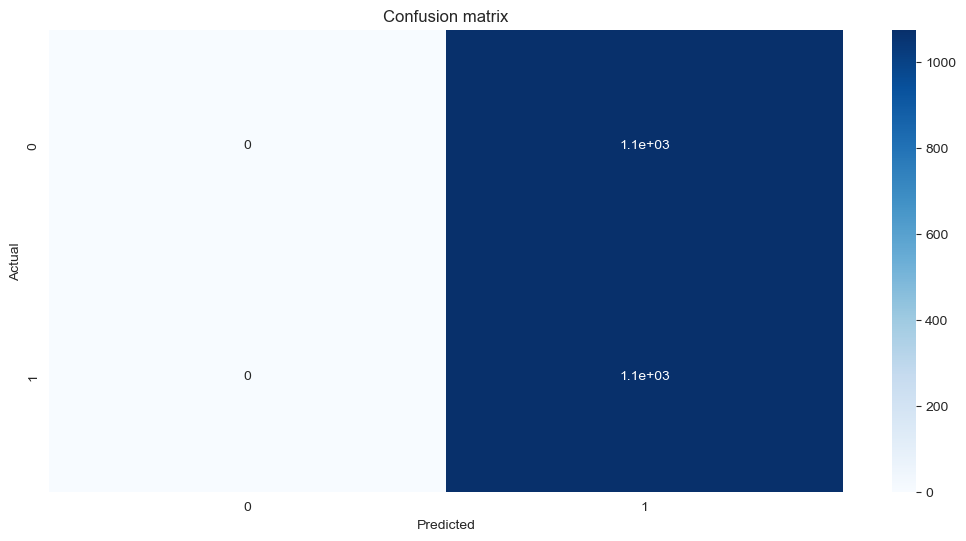

In [52]:

best_svm.fit(X_train_pca, y_train)
svm_pred = best_svm.predict(X_val_pca)

f1,acc = display_results(pd.DataFrame(y_val)[0],pd.DataFrame(svm_pred)[0])

In [53]:
model = Sequential()
model.add(Dense(15, input_dim=15, activation='relu'))
model.add(Dense(6, activation='relu'))
model.add(Dense(1, activation='softmax'))
optimizer = SGD(learning_rate=0.3, momentum=0.2)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])



In [54]:
model = Sequential()
model.add(Dense(6, input_dim=6, activation='relu'))
model.add(Dense(15, activation='relu'))
model.add(Dense(30, activation='relu'))
# model.add(Dense(5, activation='relu'))
model.add(Dense(3, activation='relu'))
# model.add(Dense(2, activation='softmax'))
model.add(Dense(1, activation='softmax'))
optimizer = SGD(
    learning_rate=0.01
                # , momentum=0.2
                )
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])



In [55]:
model.fit(X_train_pca
          , y_train
          ,validation_data=(X_val_pca,y_val)
        ,epochs=100
          )

Epoch 1/100
157/157 [==============================] - 1s 3ms/step - loss: 0.6932 - accuracy: 0.4973 - val_loss: 0.6932 - val_accuracy: 0.5007
Epoch 2/100
157/157 [==============================] - 0s 2ms/step - loss: 0.6932 - accuracy: 0.4973 - val_loss: 0.6932 - val_accuracy: 0.5007
Epoch 3/100
157/157 [==============================] - 0s 2ms/step - loss: 0.6932 - accuracy: 0.4973 - val_loss: 0.6932 - val_accuracy: 0.5007
Epoch 4/100
157/157 [==============================] - 0s 2ms/step - loss: 0.6932 - accuracy: 0.4973 - val_loss: 0.6932 - val_accuracy: 0.5007
Epoch 5/100
157/157 [==============================] - 0s 2ms/step - loss: 0.6932 - accuracy: 0.4973 - val_loss: 0.6932 - val_accuracy: 0.5007
Epoch 6/100
157/157 [==============================] - 0s 2ms/step - loss: 0.6932 - accuracy: 0.4973 - val_loss: 0.6932 - val_accuracy: 0.5007
Epoch 7/100
157/157 [==============================] - 0s 2ms/step - loss: 0.6932 - accuracy: 0.4973 - val_loss: 0.6932 - val_accuracy: 0.5007

In [56]:

model_pred = model.predict(X_val_pca)
model_pred

68/68 [==============================] - 0s 941us/step


array([[1.],
       [1.],
       [1.],
       ...,
       [1.],
       [1.],
       [1.]], dtype=float32)

              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000      1071
           1     0.5007    1.0000    0.6673      1074

    accuracy                         0.5007      2145
   macro avg     0.2503    0.5000    0.3336      2145
weighted avg     0.2507    0.5007    0.3341      2145



c:\Users\Vinícius\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Vinícius\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Vinícius\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


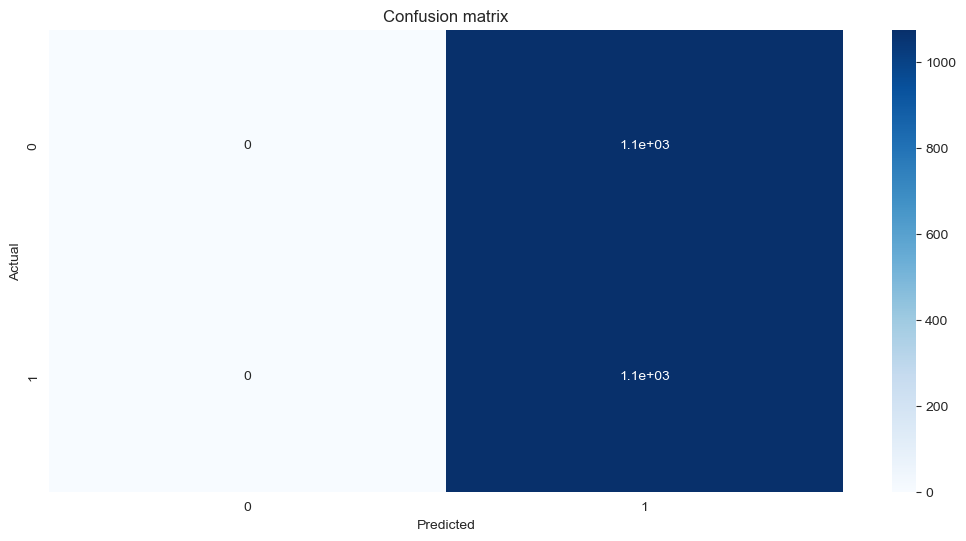

In [57]:

f1,acc = display_results(pd.DataFrame(y_val)[0],pd.DataFrame(model_pred)[0])

In [58]:
umap = UMAP(n_components=6, random_state=42,n_neighbors=30,min_dist=0.05)
umap.fit(X_train,y_train)


X_train_umap = umap.transform(X_train)
X_val_umap = umap.transform(X_val)


c:\Users\Vinícius\anaconda3\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [59]:
# skf = StratifiedKFold(n_splits=n_folds, shuffle=False, random_state=42)
# Iterar sobre os folds
# for train_index, test_index in skf.split(X_train_full, y_train_full):

# Definir o número de folds para a validação cruzada


model = MLPClassifier(learning_rate_init= 0.3,max_iter= 500,momentum= 0.2,hidden_layer_sizes= (6, 4))

random_grid = {
               'activation': ['relu','logistic','tanh'],
               'solver': ['sgd','adam','lbfgs'],
               
               
               }


random_search = RandomizedSearchCV(estimator= model,param_distributions=random_grid,refit='Accuracy',scoring={'F1': 'f1_macro', 'Accuracy': make_scorer(accuracy_score)})
# Criar o modelo da rede neural

random_search.fit(X_train_umap, y_train)



c:\Users\Vinícius\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:307: UserWarning: The total space of parameters 9 is smaller than n_iter=10. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


RandomizedSearchCV(estimator=MLPClassifier(hidden_layer_sizes=(6, 4),
                                           learning_rate_init=0.3, max_iter=500,
                                           momentum=0.2),
                   param_distributions={'activation': ['relu', 'logistic',
                                                       'tanh'],
                                        'solver': ['sgd', 'adam', 'lbfgs']},
                   refit='Accuracy',
                   scoring={'Accuracy': make_scorer(accuracy_score),
                            'F1': 'f1_macro'})

In [60]:
results = random_search.cv_results_

best_svm = random_search.best_estimator_ 
best_scorer_index = np.nonzero(results['rank_test_Accuracy'] == 1)[0][0]
best_svm.get_params()



{'activation': 'logistic',
 'alpha': 0.0001,
 'batch_size': 'auto',
 'beta_1': 0.9,
 'beta_2': 0.999,
 'early_stopping': False,
 'epsilon': 1e-08,
 'hidden_layer_sizes': (6, 4),
 'learning_rate': 'constant',
 'learning_rate_init': 0.3,
 'max_fun': 15000,
 'max_iter': 500,
 'momentum': 0.2,
 'n_iter_no_change': 10,
 'nesterovs_momentum': True,
 'power_t': 0.5,
 'random_state': None,
 'shuffle': True,
 'solver': 'sgd',
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': False,
 'warm_start': False}

              precision    recall  f1-score   support

           0     0.5000    0.4444    0.4706      1071
           1     0.5013    0.5568    0.5276      1074

    accuracy                         0.5007      2145
   macro avg     0.5006    0.5006    0.4991      2145
weighted avg     0.5006    0.5007    0.4991      2145



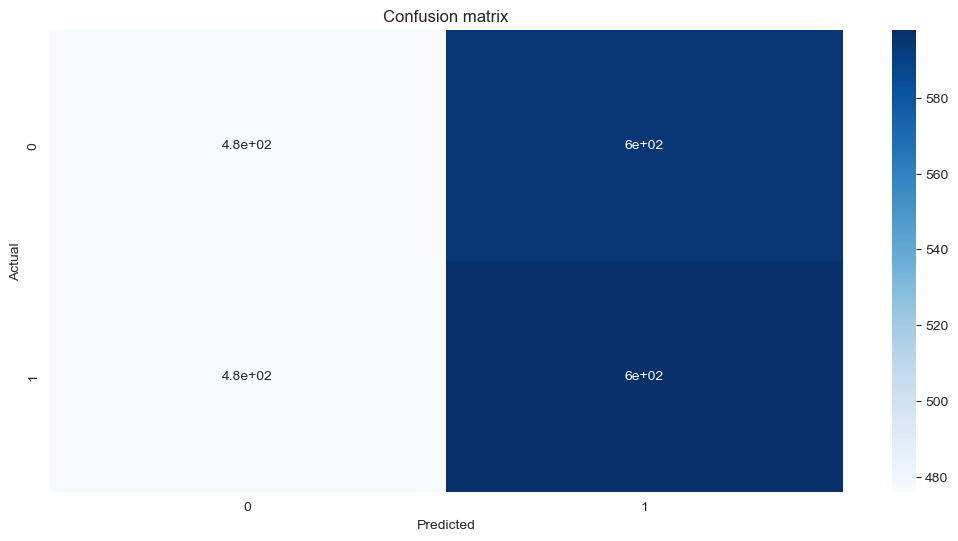

In [61]:
best_svm.fit(X_train_umap, y_train)
svm_pred_umap = best_svm.predict(X_val_umap)

f1,acc = display_results(pd.DataFrame(y_val)[0],pd.DataFrame(svm_pred_umap)[0])

In [62]:
model = Sequential()
model.add(Dense(6, input_dim=6, activation='relu'))
model.add(Dense(15, activation='relu'))
model.add(Dense(30, activation='relu'))
# model.add(Dense(5, activation='relu'))
model.add(Dense(3, activation='relu'))
# model.add(Dense(2, activation='softmax'))
model.add(Dense(1, activation='softmax'))
optimizer = SGD(
    learning_rate=0.01
                # , momentum=0.2
                )
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model.fit(X_train_umap, y_train
          ,validation_data=(X_val_umap,y_val)
        ,epochs=100
          )


Epoch 1/100
157/157 [==============================] - 1s 3ms/step - loss: 0.6937 - accuracy: 0.4973 - val_loss: 0.6932 - val_accuracy: 0.5007
Epoch 2/100
157/157 [==============================] - 0s 2ms/step - loss: 0.6932 - accuracy: 0.4973 - val_loss: 0.6932 - val_accuracy: 0.5007
Epoch 3/100
157/157 [==============================] - 0s 2ms/step - loss: 0.6932 - accuracy: 0.4973 - val_loss: 0.6932 - val_accuracy: 0.5007
Epoch 4/100
157/157 [==============================] - 0s 2ms/step - loss: 0.6932 - accuracy: 0.4973 - val_loss: 0.6932 - val_accuracy: 0.5007
Epoch 5/100
157/157 [==============================] - 0s 2ms/step - loss: 0.6932 - accuracy: 0.4973 - val_loss: 0.6932 - val_accuracy: 0.5007
Epoch 6/100
157/157 [==============================] - 0s 2ms/step - loss: 0.6932 - accuracy: 0.4973 - val_loss: 0.6932 - val_accuracy: 0.5007
Epoch 7/100
157/157 [==============================] - 0s 2ms/step - loss: 0.6932 - accuracy: 0.4973 - val_loss: 0.6932 - val_accuracy: 0.5007

68/68 [==============================] - 0s 821us/step
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000      1071
           1     0.5007    1.0000    0.6673      1074

    accuracy                         0.5007      2145
   macro avg     0.2503    0.5000    0.3336      2145
weighted avg     0.2507    0.5007    0.3341      2145



c:\Users\Vinícius\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Vinícius\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Vinícius\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


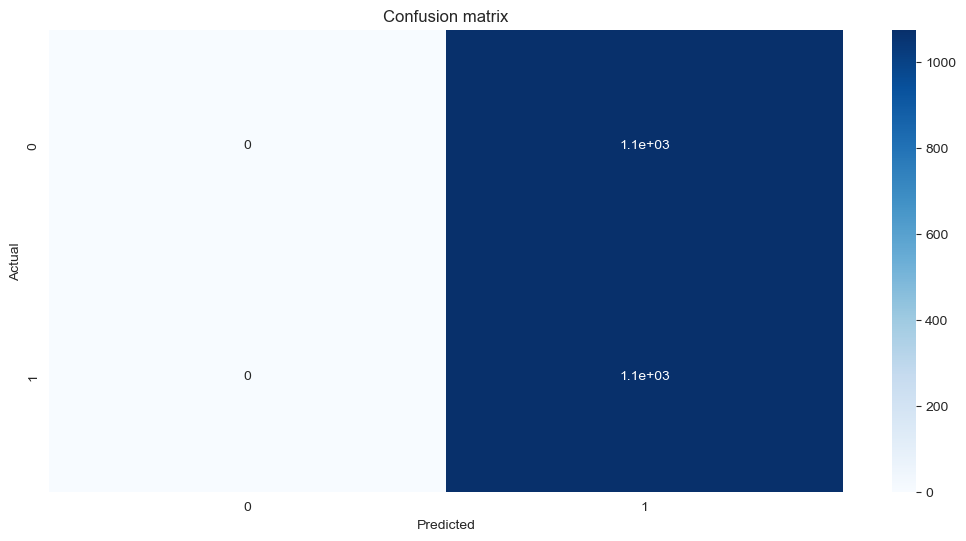

In [63]:
model_pred_umap = model.predict(X_val_umap)
model_pred_umap
f1,acc = display_results(pd.DataFrame(y_val)[0],pd.DataFrame(model_pred_umap)[0])

In [65]:

from sklearn.naive_bayes import MultinomialNB 

In [66]:
mnbc = MultinomialNB()
mnbc
     

MultinomialNB()

In [67]:

from sklearn.model_selection import cross_validate

In [76]:
score_metrics = {'F1': 'f1_macro', 'Accuracy': make_scorer(accuracy_score)}
scores = cross_validate(mnbc, abs(pd.DataFrame(X_train_umap)), y_train, cv=10,scoring=score_metrics, return_train_score=True)

In [77]:
print(scores.keys())
print(scores['test_F1'])  

dict_keys(['fit_time', 'score_time', 'test_F1', 'train_F1', 'test_Accuracy', 'train_Accuracy'])
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


              precision    recall  f1-score   support

           0       0.51      0.42      0.46      1071
           1       0.51      0.60      0.55      1074

    accuracy                           0.51      2145
   macro avg       0.51      0.51      0.50      2145
weighted avg       0.51      0.51      0.50      2145



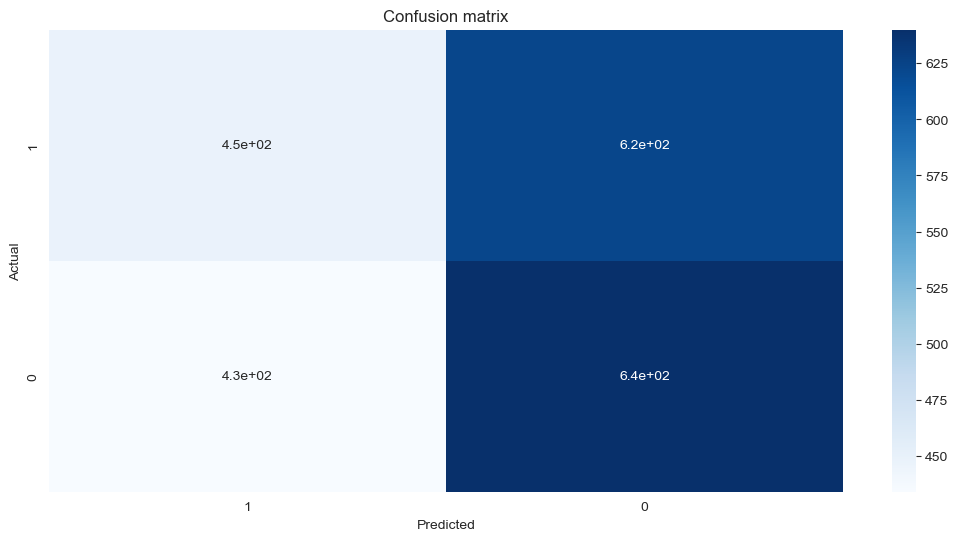

In [85]:
mnbc.fit(abs(pd.DataFrame(X_train_umap)), y_train)
mnbc_pred = mnbc.predict(abs(pd.DataFrame(X_val_umap)))

acc = accuracy_score(y_val, mnbc_pred)
f1 = f1_score(y_val, mnbc_pred, average='macro')
print(classification_report(y_val,mnbc_pred))

aux_df = metricsT1['target'].drop_duplicates()
conf_matrix = confusion_matrix(y_val, mnbc_pred)
plt.figure(figsize=(12.8,6))
sns.heatmap(conf_matrix, 
            annot=True,
            xticklabels=aux_df.values, 
            yticklabels=aux_df.values,
            cmap="Blues")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion matrix')
plt.show()